In [1]:
import torch
from tqdm import tqdm
# Check if CUDA is available and being used
cuda_available = torch.cuda.is_available()
current_device = torch.cuda.current_device() if cuda_available else 'CPU'
device_name = torch.cuda.get_device_name(current_device) if cuda_available else 'CPU'

print(f"CUDA Available: {cuda_available}")
print(f"Current Device: {current_device}")
print(f"Device Name: {device_name}")

CUDA Available: True
Current Device: 0
Device Name: NVIDIA TITAN X (Pascal)


In [2]:
import json
import matplotlib.pyplot as plt
from os import path
from torch.utils.data import DataLoader

from models.glow_model.train import get_ds_params
from models.glow_model.model import Glow
from utilities.routes import OUTPUT_DIR

device = torch.device("cuda")
def load_model(ds_name, checkpoint, device):
    
    transform =None
    dataset_output = "output_full_train/"
    # dataset_output = "output_lastresult/"
    model_type = 'glow'

    dataset_output_dir = path.join(dataset_output, f"{model_type}_{ds_name}/")

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
    image_shape, num_classes, _, test_ds = get_ds_params(ds_name, hparams['dataroot'], transform, hparams['augment'], hparams['download'],mode='test')
    model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
                hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
                hparams['learn_top'], hparams['y_condition'])

    model.load_state_dict(torch.load(dataset_output_dir + checkpoint)['model']) # Load only model part
    model.set_actnorm_init()

    model = model.to(device)

    model = model.eval()
    return test_ds, model

/export/home/bmontaze/behrooz_vscode/repos/ood_detections/.venv/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [3]:
def compute_nll(dataset, model):
    # dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=6)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False)
    nlls = []
    for x,y in dataloader:
        x = x.to(device)
        y = None
        
        with torch.no_grad():
            _, nll, _ = model(x, y_onehot=y)
            nlls.append(nll)
        
    return torch.cat(nlls).cpu()

In [5]:
epoch = 250 #10 250
if epoch==1:
    cifar10_chk = 'glow_checkpoint_781.pt'
    svhn_chk = 'glow_checkpoint_1144.pt'
    imagenet32_chk = 'glow_checkpoint_2001.pt'
    celeba_chk = 'glow_checkpoint_2532.pt'
    gtsrb_chk = 'glow_checkpoint_416.pt'
    epo_info = "One epoch"
elif epoch==10:
    cifar10_chk = 'glow_checkpoint_7810.pt'
    svhn_chk = 'glow_checkpoint_11440.pt'
    imagenet32_chk = 'glow_checkpoint_20010.pt'
    celeba_chk = 'glow_checkpoint_25320.pt'
    gtsrb_chk = 'glow_checkpoint_4160.pt'
    epo_info = "Ten epochs"
elif epoch==250:
    cifar10_chk = 'glow_checkpoint_195250.pt'
    svhn_chk = 'glow_checkpoint_286000.pt'
    imagenet32_chk = 'glow_checkpoint_500250.pt'
    celeba_chk = 'glow_checkpoint_633000.pt'
    gtsrb_chk = 'glow_checkpoint_104000.pt'
    epo_info = "Fully trained"

def load_ds(ds_name):
    
    transform =None
    dataset_output = "output_full_train/"
    # dataset_output = "output_lastresult/"
    model_type = 'glow'

    dataset_output_dir = path.join(dataset_output, f"{model_type}_{ds_name}/")

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
    image_shape, num_classes, _, test_ds = get_ds_params(ds_name, hparams['dataroot'], transform, hparams['augment'], hparams['download'],mode='test')
    return test_ds

# gtsrb_test, model = load_model('gtsrb', gtsrb_chk, device)
# gtsrb_nll = compute_nll(gtsrb_test, model)
svhn_test, model = load_model('svhn', svhn_chk, device)
svhn_nll = compute_nll(svhn_test, model)
imagenet32_test = load_ds('imagenet32')
imagenet32_nll = compute_nll(imagenet32_test, model)
cifar_test = load_ds('cifar10')
cifar_nll = compute_nll(cifar_test, model)
celeba_test = load_ds('celeba')
celeba_nll = compute_nll(celeba_test, model)
gtsrb_test = load_ds('gtsrb')
gtsrb_nll = compute_nll(gtsrb_test, model)


print("CIFAR NLL", torch.mean(cifar_nll))
print("SVHN NLL", torch.mean(svhn_nll))
print("Imagenet32 NLL", torch.mean(imagenet32_nll))
print("Celeba NLL", torch.mean(celeba_nll))
print("GTSRB NLL", torch.mean(gtsrb_nll))

/tmp/ipykernel_1677431/458778599.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(dataset_output_dir + checkpoint)['model']) # Load only

Total entries in LMDB: 50000


Loading validation data of ImageNet32: 100%|██████████| 50000/50000 [00:09<00:00, 5059.82it/s]


Total entries in LMDB split): 40520


Loading validation data of CelebA: 100%|██████████| 40520/40520 [00:21<00:00, 1894.82it/s]


CIFAR NLL tensor(3.8743)
SVHN NLL tensor(2.1234)
Imagenet32 NLL tensor(3.8193)
Celeba NLL tensor(3.8719)
GTSRB NLL tensor(3.5857)


In [4]:
# # Compute nll under GLOW model
# epoch = 10 #10 250
# if epoch==1:
#     cifar10_chk = 'glow_checkpoint_781.pt'
#     svhn_chk = 'glow_checkpoint_1144.pt'
#     imagenet32_chk = 'glow_checkpoint_2001.pt'
#     celeba_chk = 'glow_checkpoint_2532.pt'
#     gtsrb_chk = 'glow_checkpoint_416.pt'
#     epo_info = "One epoch"
# elif epoch==10:
#     cifar10_chk = 'glow_checkpoint_7810.pt'
#     svhn_chk = 'glow_checkpoint_11440.pt'
#     imagenet32_chk = 'glow_checkpoint_20010.pt'
#     celeba_chk = 'glow_checkpoint_25320.pt'
#     gtsrb_chk = 'glow_checkpoint_4160.pt'
#     epo_info = "Ten epochs"
# elif epoch==250:
#     cifar10_chk = 'glow_checkpoint_195250.pt'
#     svhn_chk = 'glow_checkpoint_286000.pt'
#     imagenet32_chk = 'glow_checkpoint_500250.pt'
#     celeba_chk = 'glow_checkpoint_633000.pt'
#     gtsrb_chk = 'glow_checkpoint_104000.pt'
#     epo_info = "Fully trained"



# cifar_test, cifar_model = load_model('cifar10', cifar10_chk, device)
# cifar_nll = compute_nll(cifar_test, cifar_model)
# svhn_test, svhn_model = load_model('svhn', svhn_chk, device)
# svhn_nll = compute_nll(svhn_test, svhn_model)
# imagenet32_test, imagenet32_model = load_model('imagenet32', imagenet32_chk, device)
# imagenet32_nll = compute_nll(imagenet32_test, imagenet32_model)
# celeba_test, celeba_model = load_model('celeba', celeba_chk, device)
# celeba_nll = compute_nll(celeba_test, celeba_model)
# gtsrb_test, gtsrb_model = load_model('gtsrb', gtsrb_chk, device)
# gtsrb_nll = compute_nll(gtsrb_test, gtsrb_model)


# print("CIFAR NLL", torch.mean(cifar_nll))
# print("SVHN NLL", torch.mean(svhn_nll))
# print("Imagenet32 NLL", torch.mean(imagenet32_nll))
# print("Celeba NLL", torch.mean(celeba_nll))
# print("GTSRB NLL", torch.mean(gtsrb_nll))

/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/models/glow_model/modules.py:482: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  w_init = torch.qr(torch.randn(*w_shape))[0]
/export/home/bmontaze/behrooz_vscode/repos/ood_detections/.venv/lib/python3.10/site-packages/torch/functional.py:1924: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced 

Using downloaded and verified file: /net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/data/SVHN/test_32x32.mat


/tmp/ipykernel_1643477/1926424858.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(dataset_output_dir + checkpoint)['model']) # Load onl

Total entries in LMDB: 50000


Loading validation data of ImageNet32: 100%|██████████| 50000/50000 [00:09<00:00, 5094.79it/s]


Total entries in LMDB split): 40520


Loading validation data of CelebA: 100%|██████████| 40520/40520 [00:21<00:00, 1890.17it/s]


CIFAR NLL tensor(3.6773)
SVHN NLL tensor(2.2632)
Imagenet32 NLL tensor(3.2626)
Celeba NLL tensor(3.3650)
GTSRB NLL tensor(3.2675)


In [5]:
nll_data = {
    "cifar_nll": cifar_nll.tolist(),
    "svhn_nll": svhn_nll.tolist(),
    "imagenet32_nll": imagenet32_nll.tolist(),
    "celeba_nll": celeba_nll.tolist(),
    "gtsrb_nll": gtsrb_nll.tolist()
}
output_file = path.join("images", "nll_data_under_cifar_model_one_epoch.json")
with open(output_file, 'w') as f:
    json.dump(nll_data, f)

In [18]:
import numpy as np
# output_file = path.join("images/fully_trained/", "nll_data_fully_trained.json")
# output_file = path.join("images/ten_epochs/", "nll_data_ten_epochs.json")
output_file = path.join("images/one_epoch/", "nll_data_one_epoch.json")
with open(output_file, 'r') as nll_data:
    output = json.load(nll_data)

cifar_nll = output["cifar_nll"]
svhn_nll = output["svhn_nll"]
imagenet32_nll = output["imagenet32_nll"]
celeba_nll = output["celeba_nll"]
gtsrb_nll = output["gtsrb_nll"]

print("CIFAR NLL", np.mean(cifar_nll))
print("SVHN NLL", np.mean(svhn_nll))
print("Imagenet32 NLL", np.mean(imagenet32_nll))
print("Celeba NLL", np.mean(celeba_nll))
print("GTSRB NLL", np.mean(gtsrb_nll))

CIFAR NLL 4.264880203771591
SVHN NLL 2.5720091812500354
Imagenet32 NLL 3.8097166062021257
Celeba NLL 3.824129492138592
GTSRB NLL 3.8120213098688343


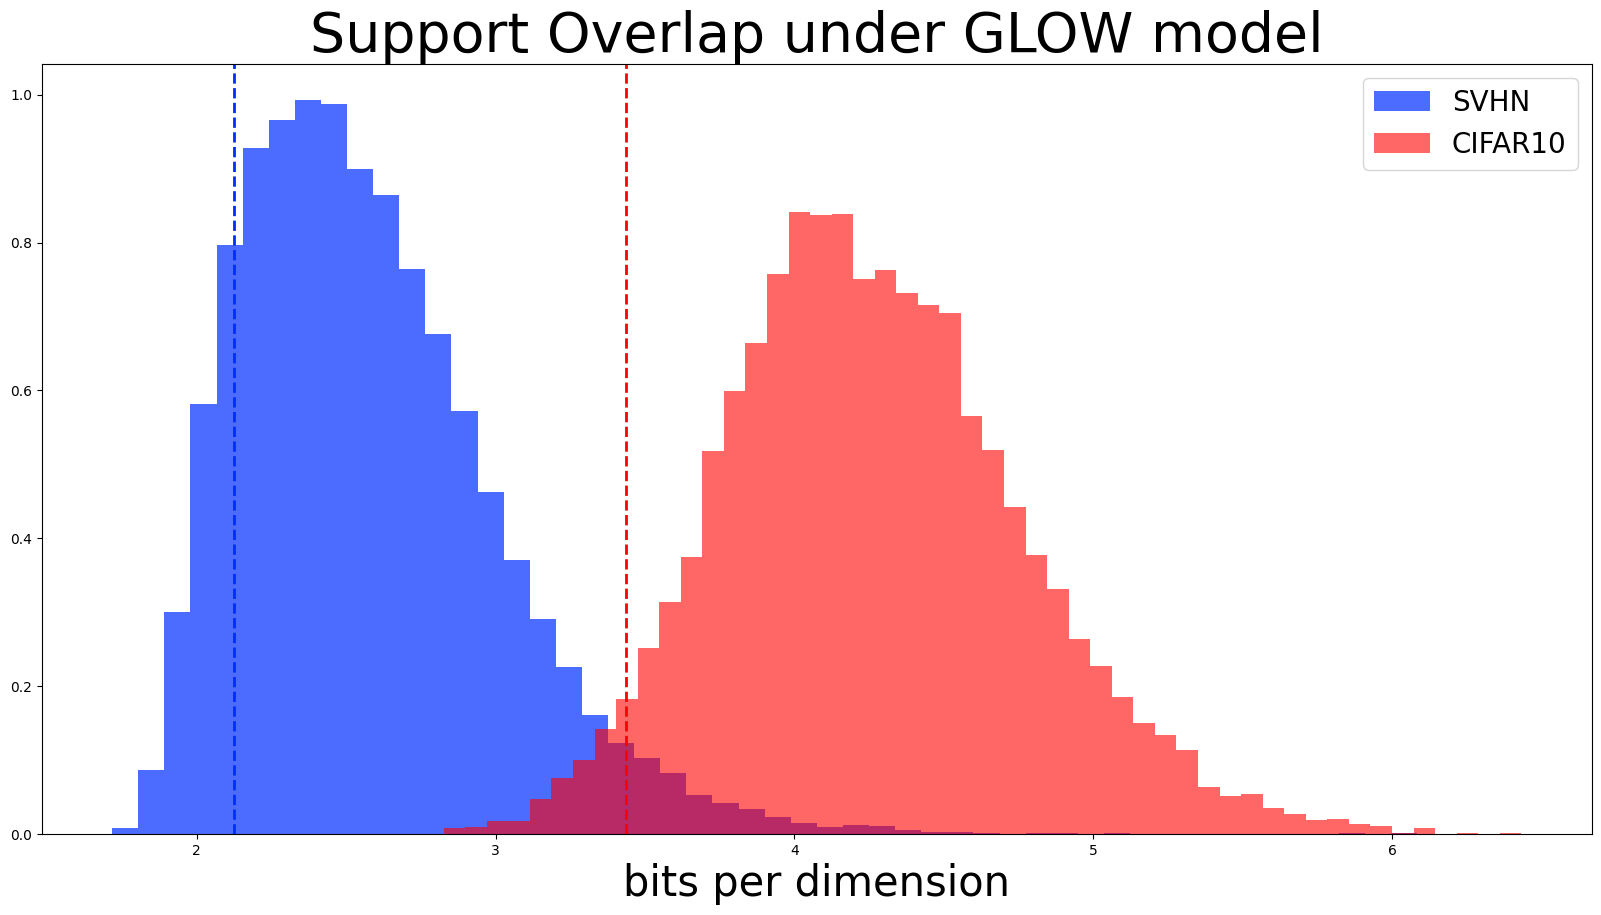

In [19]:
# 250
# CIFAR NLL 3.435947921139002
# SVHN NLL 2.1234527845771383
# Imagenet32 NLL 2.861192772409916
# Celeba NLL 3.180525192383011
# GTSRB NLL 2.747616269176948
#10
# CIFAR NLL 3.6773196013689042
# SVHN NLL 2.263177738811754
# Imagenet32 NLL 3.262624274442196
# Celeba NLL 3.3650425261800403
# GTSRB NLL 3.267467555778893
#1
# CIFAR NLL 4.264880203771591
# SVHN NLL 2.5720091812500354
# Imagenet32 NLL 3.8097166062021257
# Celeba NLL 3.824129492138592
# GTSRB NLL 3.8120213098688343

plt.figure(figsize=(20,10))
plt.title(f"Support Overlap under GLOW model",fontsize=40) #- {epo_info}")
plt.xlabel("bits per dimension", fontsize=30)

# imagenet32_nll = imagenet32_nll[~torch.isinf(imagenet32_nll)]
# imagenet32_nll = imagenet32_nll[imagenet32_nll < -6]
# plt.hist(-imagenet32_nll.numpy(), label="Imagenet32", density=True, bins=50, alpha=0.6, color='#00FF11', edgecolor='black')

plt.hist(svhn_nll, label="SVHN", density=True, bins=50, alpha=0.7,color='#002CFF')
plt.hist(cifar_nll, label="CIFAR10", density=True, bins=50, alpha=0.6, color='#FF0000')
# plt.hist(celeba_nll.numpy(), label="Celeba", density=True, bins=50, alpha=0.6,color='#F0FF00', edgecolor='black')
# plt.hist(imagenet32_nll.numpy(), label="Imagenet32", density=True, bins=50, alpha=0.6, color='#00FF11', edgecolor='black')
# plt.hist(gtsrb_nll.numpy(), label="GTSRB", density=True, bins=30, alpha=0.7,color='#00FAFF', edgecolor='black')
plt.axvline(x=2.1234527845771383, color='#002CFF', linestyle='dashed', linewidth=2)
plt.axvline(x=3.435947921139002, color='#FF0000', linestyle='dashed', linewidth=2)
plt.legend(fontsize=20)
output_path = path.join("images", "Support_overlap_svhn_cifar10_1.png")
plt.savefig(output_path)
plt.show()
